In [1]:
#!/usr/bin/env python3
"""
Compute Pi to N decimal places and analyze digit patterns:
- counts of each digit 0-9 (and percentages)
- number of overlapping instances of 2 same digits in a row
- number of overlapping instances of 5 same digits in a row
- runs of 7 or more same digits in a row (reported with digit, length, start position)

Usage in notebook: run the cell (argument parsing is disabled for notebook).
To run as a script from terminal, change the parse line to parser.parse_args()
"""
from decimal import Decimal, getcontext
from collections import Counter
import re
import argparse

def compute_pi_decimal_string(n_digits, extra=20, verbose=True, progress_step=1000):
    """
    Compute pi to n_digits after decimal using Machin-like formula and Decimal.
    Returns the full decimal string like '3.<digits...>'.

    - extra: additional precision guard digits (default 20)
    - verbose: print lightweight progress messages (default True)
    - progress_step: print an update every progress_step iterations inside series
    """
    # set internal precision
    getcontext().prec = n_digits + extra

    def arctan(x, name="arctan"):
        x = Decimal(x)
        x2 = x * x
        term = x
        total = term
        k = 1
        # stop when term is smaller than required precision
        limit = Decimal(10) ** (-(n_digits + extra - 2))
        if verbose:
            print(f"  {name}: starting series (convergence limit ≈ {limit})")
        while True:
            term = -term * x2
            denom = Decimal(2 * k + 1)
            term_div = term / denom
            total += term_div
            # light progress update for long runs
            if verbose and k % progress_step == 0:
                # show approximate magnitude of current term
                try:
                    mag = f"{abs(term_div):.2E}"
                except Exception:
                    mag = str(abs(term_div))
                print(f"    {name}: iteration {k}, current term ≈ {mag}")
            if abs(term_div) < limit:
                if verbose:
                    print(f"  {name}: converged after {k} iterations")
                break
            k += 1
        return total

    if verbose:
        print(f"Computing pi to {n_digits} decimal places (internal precision={getcontext().prec})")
    # Machin formula: pi/4 = 4*arctan(1/5) - arctan(1/239)
    a1 = arctan(Decimal(1) / Decimal(5), name="arctan(1/5)")
    a2 = arctan(Decimal(1) / Decimal(239), name="arctan(1/239)")
    pi = (Decimal(4) * (Decimal(4) * a1 - a2))
    if verbose:
        print("Assembled pi value; formatting to string...")
    s = format(pi, 'f')  # decimal fixed-format

    # Ensure we have at least n_digits after the decimal; if rounding trimmed digits, increase precision and retry
    if '.' in s:
        intpart, frac = s.split('.')
        if len(frac) < n_digits:
            if verbose:
                print(f"  Warning: produced only {len(frac)} fractional digits; increasing precision and retrying...")
            return compute_pi_decimal_string(n_digits, extra=extra*2, verbose=verbose, progress_step=progress_step)
    else:
        if verbose:
            print("  Warning: no decimal point found; increasing precision and retrying...")
        return compute_pi_decimal_string(n_digits, extra=extra*2, verbose=verbose, progress_step=progress_step)

    if verbose:
        print("Pi computation complete.")
    return s

def analyze_digits(frac_digits):
    """
    frac_digits: string of digits (only fractional part, length N)
    Returns analysis dict.
    """
    N = len(frac_digits)
    counts = Counter(frac_digits)
    percentages = {d: (counts.get(d, 0) / N) * 100 for d in [str(i) for i in range(10)]}

    # overlapping pairs of same digit: look for (?=(\d)\1)
    pair_pattern = re.compile(r'(?=(\d)\1)')
    pair_count = len(list(pair_pattern.finditer(frac_digits)))

    # overlapping runs of 5 same digits: (?=(\d)\1{4})
    five_pattern = re.compile(r'(?=(\d)\1{4})')
    five_count = len(list(five_pattern.finditer(frac_digits)))

    # runs of length >=7: find maximal runs and accept those with length>=7
    runs_pattern = re.compile(r'((\d)\2*)')  # matches runs; group 1 is run
    runs = []
    for m in runs_pattern.finditer(frac_digits):
        run = m.group(1)
        if len(run) >= 7:
            runs.append({
                'digit': run[0],
                'length': len(run),
                # start position as 1-based index into fractional digits
                'start_index': m.start() + 1,
                'run_string': run
            })

    return {
        'total_digits': N,
        'counts': counts,
        'percentages': percentages,
        'pair_count': pair_count,
        'five_count': five_count,
        'runs_ge_7': runs
    }

def pretty_print_analysis(result, head_intpart='3'):
    N = result['total_digits']
    print(f"\nAnalyzed {N} fractional digits of pi (fractional part only).")

    print("\nDigit counts (digit: count, percentage):")
    for d in range(10):
        s = str(d)
        cnt = result['counts'].get(s, 0)
        pct = result['percentages'].get(s, 0.0)
        print(f" {s}: {cnt:7d}  {pct:6.3f}%")
    print()

    print(f"Overlapping instances of 2 same digits in a row: {result['pair_count']}")
    print(f"Overlapping instances of 5 same digits in a row: {result['five_count']}")
    print()

    runs = result['runs_ge_7']
    if runs:
        print(f"Runs of length >= 7 (count={len(runs)}):")
        for r in runs:
            print(f" - digit {r['digit']}, length {r['length']}, start at fractional position {r['start_index']}")
    else:
        print("No runs of length >= 7 found.")
    print()

def main():
    parser = argparse.ArgumentParser(description="Analyze digits of Pi.")
    parser.add_argument('--digits', '-n', type=int, default=20000,
                        help='number of decimal places of pi to analyze (default 20000)')
    # Notebook-safe: ignore kernel-injected CLI args by providing an empty args list
    args = parser.parse_args(args=[])

    n = args.digits
    # lightweight progress: only top-level messages and the compute function prints series progress
    print(f"Computing pi to {n} decimal places (this may take a while)...")
    pi_str = compute_pi_decimal_string(n, extra=20, verbose=True, progress_step=1000)
    intpart, frac = pi_str.split('.')
    frac_n = frac[:n]  # ensure exact length

    result = analyze_digits(frac_n)
    pretty_print_analysis(result)

if __name__ == "__main__":
    main()

Computing pi to 20000 decimal places (this may take a while)...
Computing pi to 20000 decimal places (internal precision=20020)
  arctan(1/5): starting series (convergence limit ≈ 1E-20018)
    arctan(1/5): iteration 1000, current term ≈ 1.15E-1402
    arctan(1/5): iteration 2000, current term ≈ 6.59E-2801
    arctan(1/5): iteration 3000, current term ≈ 5.04E-4199
    arctan(1/5): iteration 4000, current term ≈ 4.34E-5597
    arctan(1/5): iteration 5000, current term ≈ 3.99E-6995
    arctan(1/5): iteration 6000, current term ≈ 3.82E-8393
    arctan(1/5): iteration 7000, current term ≈ 3.76E-9791
    arctan(1/5): iteration 8000, current term ≈ 3.77E-11189
    arctan(1/5): iteration 9000, current term ≈ 3.85E-12587
    arctan(1/5): iteration 10000, current term ≈ 3.98E-13985
    arctan(1/5): iteration 11000, current term ≈ 4.15E-15383
    arctan(1/5): iteration 12000, current term ≈ 4.37E-16781
    arctan(1/5): iteration 13000, current term ≈ 4.63E-18179
    arctan(1/5): iteration 14000,

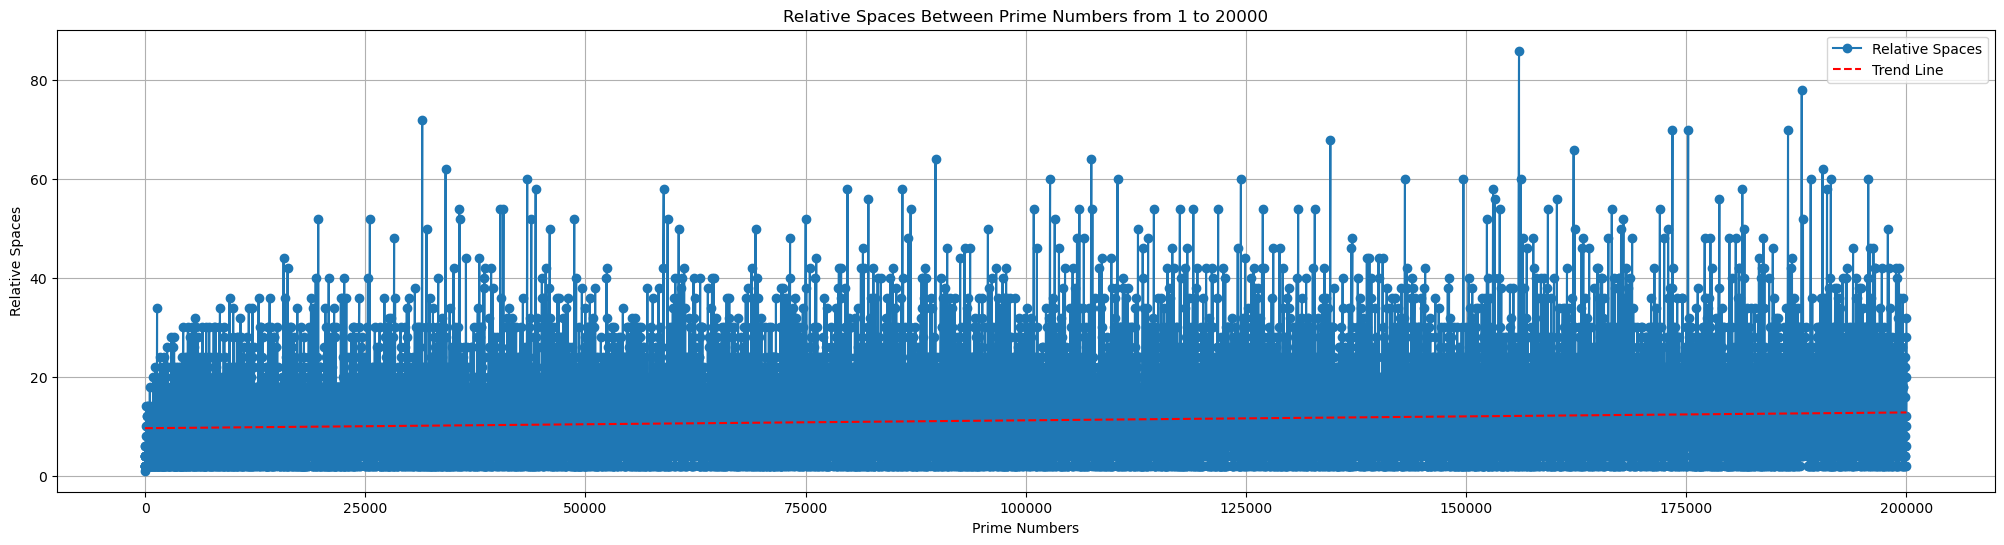

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Function to check if a number is prime (optimized: only odd divisors)
def is_prime(num):
    if num < 2:
        return False
    if num == 2:
        return True
    if num % 2 == 0:
        return False
    limit = int(num**0.5) + 1
    for i in range(3, limit, 2):   # step by 2: only odd divisors
        if num % i == 0:
            return False
    return True

# Generate prime numbers from 2 to 200000, testing only odd candidates
primes = [2] + [n for n in range(3, 200001, 2) if is_prime(n)]

# Calculate the relative spaces between primes
spaces = [primes[i] - primes[i-1] for i in range(1, len(primes))]

# Calculate the trend line
z = np.polyfit(primes[1:], spaces, 1)
p = np.poly1d(z)

# Plot the graph
plt.figure(figsize=(25, 6))
plt.plot(primes[1:], spaces, marker='o', label='Relative Spaces')
plt.plot(primes[1:], p(primes[1:]), "r--", label='Trend Line')
plt.title('Relative Spaces Between Prime Numbers from 1 to 20000')
plt.xlabel('Prime Numbers')
plt.ylabel('Relative Spaces')
plt.grid(True)
plt.legend()
plt.show()